# Eval Diffusion Model
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa

#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))
# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import conf

### Conf

In [2]:
remote_kernel: bool = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name: str = "diffusion_cifar10_v2"
training_data_name: str = "training_full_low_res"
model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Functions

In [3]:
def bwd_pass(model: Diffusion, n_samples: int = 1, file_name: str = "test") -> None:
    x: ndarray = model.bwd_diffusion(n_samples=n_samples)
    print(x[0,0].shape)
    for i in range(x.shape[0]):
        logger.info(f"Sample {i}")
        visualize_spectrogram(x[i, 0])
        audio = spectrogram_to_audio(unnormalize(x[i, 0]), conf["audio"].len_fft)
        save_audio_file(audio, path_to_remote_path("{}/{}".format(conf["paths"].result_path, f"{file_name}_{i:02d}_out.wav"), remote_kernel))
    logger.light_debug("Saved passed through samples to {}".format(conf["paths"].result_path))



def print_eval_metrics(data: ndarray) -> None:
    if data.ndim == 2:
        data = np.expand_dims(data, axis = 0)
    for i, sample in enumerate(data):
        sc_score = spectral_convergence(sample, len_fft=conf["audio"].len_fft, hop_length=conf["audio"].len_hop, sample_rate=conf["audio"].sample_rate)
        sdr_score = sdr(sample, sample_rate=conf["audio"].sample_rate, cutoff=4000)
        print(f"Sample {(i + 1):02d} Spectral Convergence: {sc_score:.4f} SDR score: {sdr_score:.2f} dB")


### Data Loading & Model Creation

In [3]:
file = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))[:100,...]
logger.info(f"Data loaded with shape: {file.shape}")

u_net = U_NET(in_channels=1,
            channels=[16, 32],
            res_blocks=[2, 4],
            factors=[2, 2],
            attentions=[0, 1], 
            attention_heads=8,
            attention_features=48,
            activation=nn.GELU(), 
            embeding_dim=conf["model"].time_embed_dim, 
            device=device
            ).to(device)

ema = None #EMA(u_net, decay = 0.999)

if os.path.exists(model_path):
    loaded_model = torch.load(model_path, map_location=device)
    u_net.load_state_dict(loaded_model["model"])
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
    if ema is not None:
        for name, param in u_net.named_parameters():
            if param.requires_grad and name in loaded_model['ema_state']:
                ema.shadow[name] = loaded_model['ema_state'][name].clone()

else:
    raise AssertionError(f"No Model with {model_name} found!")

diffusion = Diffusion(model=u_net, 
                        noise_steps=conf["model"].diffusion_timesteps, 
                        noise_schedule="cosine", 
                        input_dim= [32, 1, 32, 32],
                        ema = None,
                        device=device,
                        v_obj=False
)

2025-04-30 07:34:13,713 - LIGHT_DEBUG - Ndarray loaded from Data/training_full_low_res.npy of shape: (7087, 224, 416)
2025-04-30 07:34:13,713 - INFO - Data loaded with shape: (100, 224, 416)
2025-04-30 07:34:13,872 - INFO - Model diffusion_cifar10_v2 loaded with 312229 Parameters


### Evaluate

2025-04-30 08:07:55,902 - INFO - Started sampling 8 samples


2025-04-30 08:07:58,000 - LIGHT_DEBUG - Sampling timestep 100/1000 X min/max: -5.38865, 4.39237 noise min/max: -3.34225, 3.85042 std/mean: 0.96773, -0.00007 

2025-04-30 08:07:58,910 - LIGHT_DEBUG - Normalized to range: [-1,1]


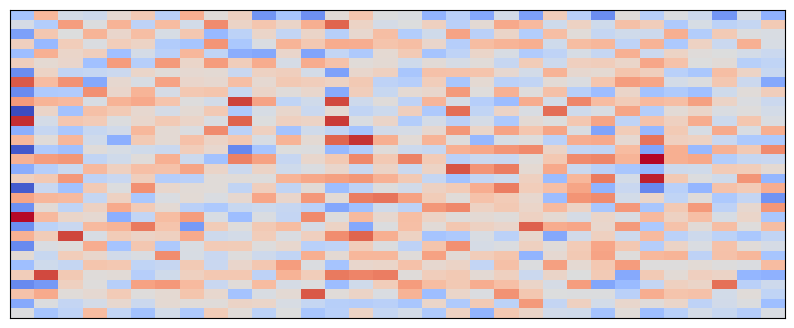

2025-04-30 08:08:01,000 - LIGHT_DEBUG - Sampling timestep 200/1000 X min/max: -5.14928, 3.89539 noise min/max: -3.91701, 3.46090 std/mean: 0.95877, -0.00022 

2025-04-30 08:08:01,918 - LIGHT_DEBUG - Normalized to range: [-1,1]


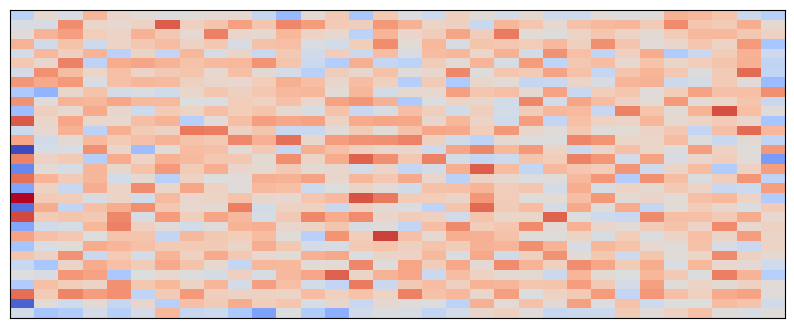

2025-04-30 08:08:04,000 - LIGHT_DEBUG - Sampling timestep 300/1000 X min/max: -4.70959, 3.98413 noise min/max: -3.61339, 3.26292 std/mean: 0.95929, -0.00060 

2025-04-30 08:08:04,988 - LIGHT_DEBUG - Normalized to range: [-1,1]


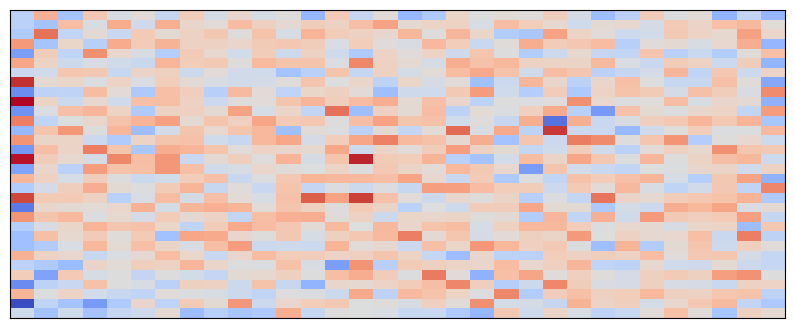

2025-04-30 08:08:07,000 - LIGHT_DEBUG - Sampling timestep 400/1000 X min/max: -4.61931, 3.26015 noise min/max: -3.71463, 3.20792 std/mean: 0.96161, 0.00085  

2025-04-30 08:08:08,007 - LIGHT_DEBUG - Normalized to range: [-1,1]


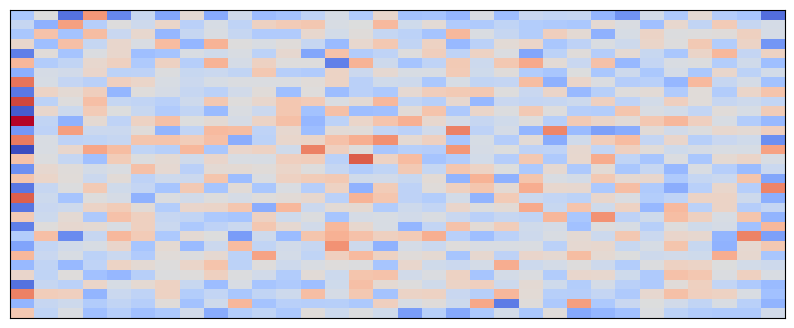

2025-04-30 08:08:11,000 - LIGHT_DEBUG - Sampling timestep 500/1000 X min/max: -4.79127, 3.02153 noise min/max: -3.28770, 3.33434 std/mean: 0.95288, -0.00034 

2025-04-30 08:08:11,072 - LIGHT_DEBUG - Normalized to range: [-1,1]


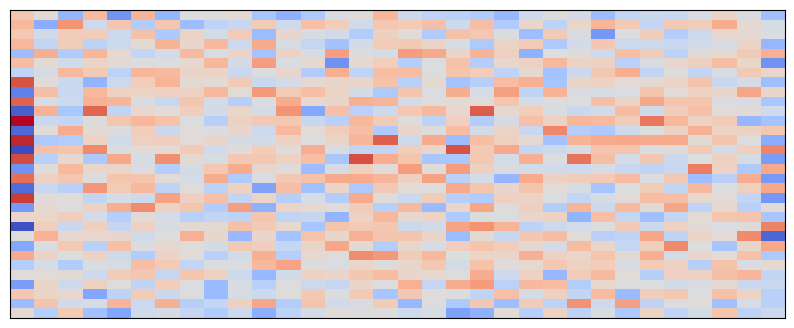

2025-04-30 08:08:14,000 - LIGHT_DEBUG - Sampling timestep 600/1000 X min/max: -4.17016, 3.47979 noise min/max: -3.24998, 3.10271 std/mean: 0.94369, 0.00082  

2025-04-30 08:08:14,233 - LIGHT_DEBUG - Normalized to range: [-1,1]


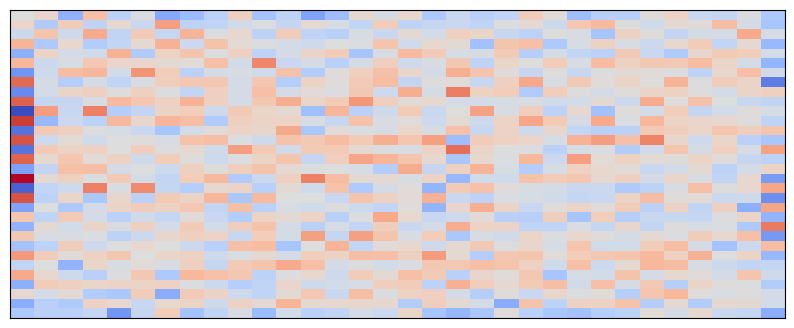

2025-04-30 08:08:17,000 - LIGHT_DEBUG - Sampling timestep 700/1000 X min/max: -4.31056, 3.49279 noise min/max: -3.60008, 3.47392 std/mean: 0.93377, -0.00084 

2025-04-30 08:08:17,248 - LIGHT_DEBUG - Normalized to range: [-1,1]


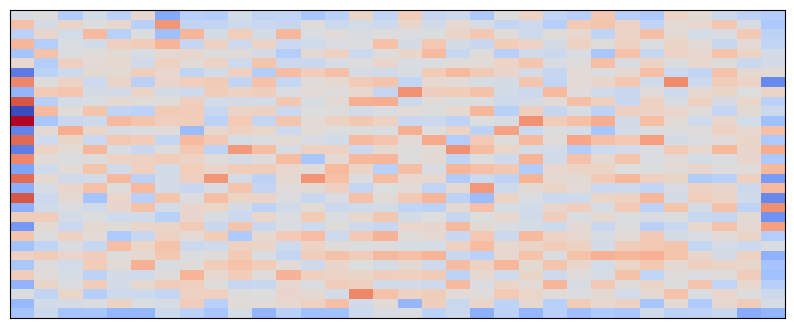

2025-04-30 08:08:20,000 - LIGHT_DEBUG - Sampling timestep 800/1000 X min/max: -4.40105, 3.66374 noise min/max: -3.47515, 3.44051 std/mean: 0.91879, -0.00091 

2025-04-30 08:08:20,309 - LIGHT_DEBUG - Normalized to range: [-1,1]


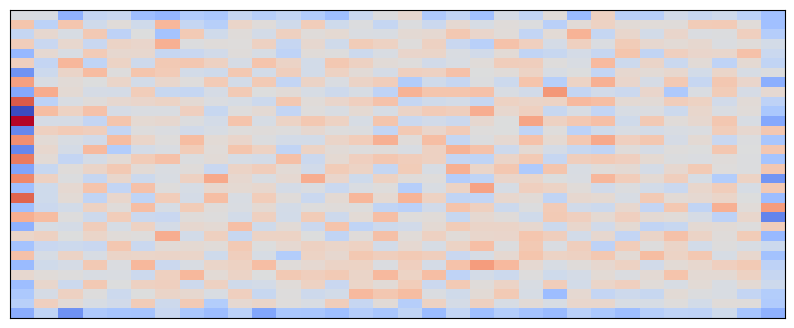

2025-04-30 08:08:23,000 - LIGHT_DEBUG - Sampling timestep 900/1000 X min/max: -3.86910, 3.82432 noise min/max: -3.18114, 3.06235 std/mean: 0.86804, 0.00095  

2025-04-30 08:08:23,347 - LIGHT_DEBUG - Normalized to range: [-1,1]


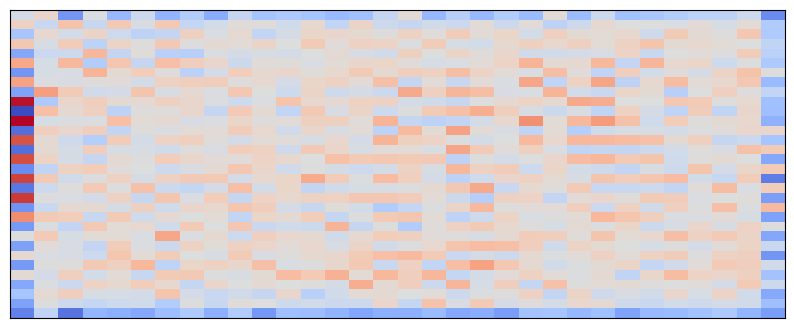

2025-04-30 08:08:26,000 - LIGHT_DEBUG - Sampling timestep 999/1000 X min/max: -3.79631, 3.44132 noise min/max: -2.05644, 1.53796 std/mean: 0.37229, 0.00182  


2025-04-30 08:08:26,406 - LIGHT_DEBUG - Final X min/max before return: -3.79631, 3.44132
2025-04-30 08:08:26,407 - INFO - Created 8 samples


In [12]:
#bwd_pass(diffusion, n_samples=8, file_name="test")
#x: ndarray = diffusion.bwd_diffusion_ddim(n_samples=8, sampling_timesteps=200, eta = 0.2)
x: ndarray = diffusion.bwd_diffusion_ddpm(n_samples=8, visual_freq=100)

-555.0492 697.3425


2025-04-30 08:07:37,486 - LIGHT_DEBUG - Normalized to range: [-1,1]


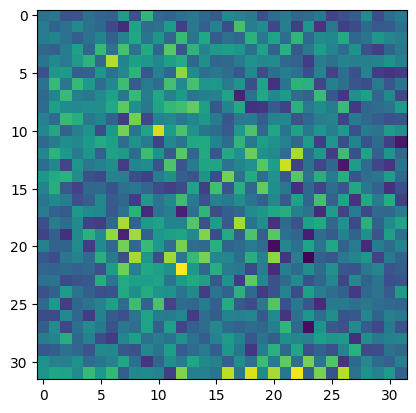

-530.63654 562.4348


2025-04-30 08:07:37,572 - LIGHT_DEBUG - Normalized to range: [-1,1]


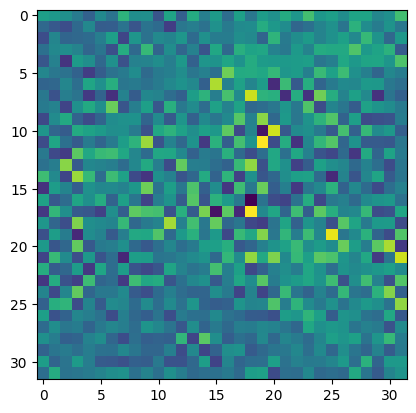

-365.577 716.23224


2025-04-30 08:07:37,650 - LIGHT_DEBUG - Normalized to range: [-1,1]


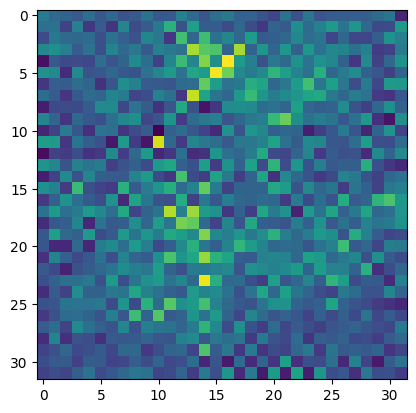

-468.42584 631.18524


2025-04-30 08:07:37,726 - LIGHT_DEBUG - Normalized to range: [-1,1]


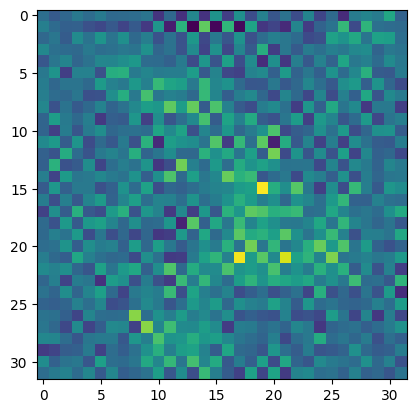

-515.226 762.812


2025-04-30 08:07:37,805 - LIGHT_DEBUG - Normalized to range: [-1,1]


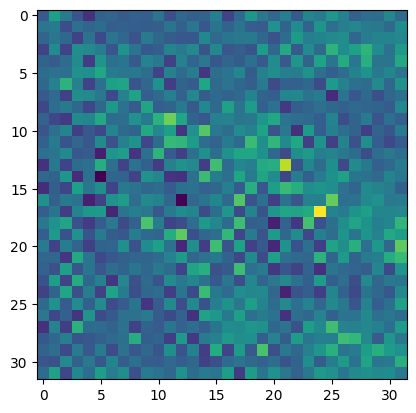

-559.93915 788.6063


2025-04-30 08:07:37,885 - LIGHT_DEBUG - Normalized to range: [-1,1]


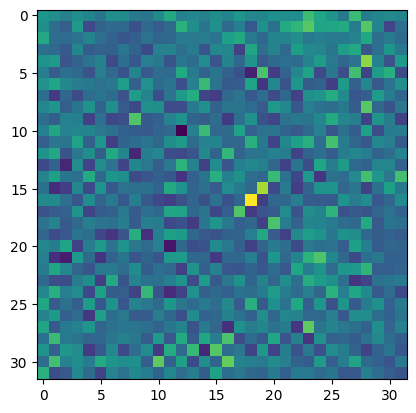

-512.2424 900.08545


2025-04-30 08:07:37,961 - LIGHT_DEBUG - Normalized to range: [-1,1]


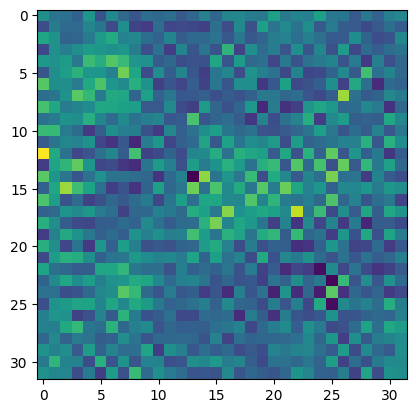

-631.41895 853.9168


2025-04-30 08:07:38,041 - LIGHT_DEBUG - Normalized to range: [-1,1]


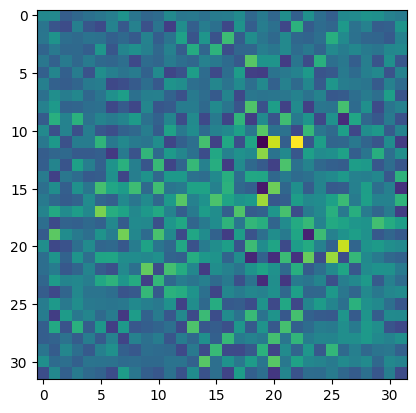

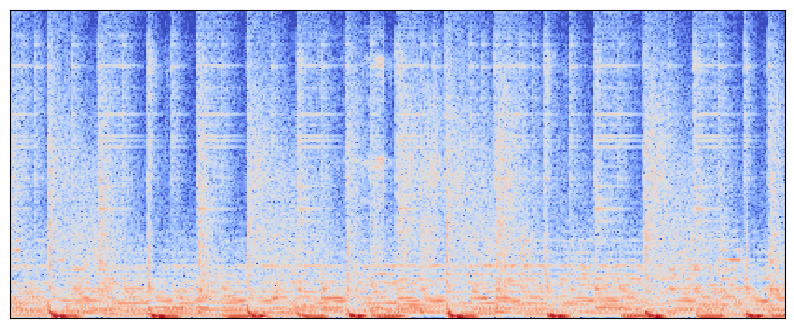

In [10]:
#print_eval_metrics(x)
for i in range(x.shape[0]):
    print(np.min(x[i,0]), np.max(x[i,0]), flush=True)
    plt.imshow(normalize(x[i,0], -1, 1))
    plt.show()
#save_audio_file(spectrogram_to_audio(unnormalize(x[0,0]), conf["audio"].len_fft, conf["audio"].len_hop), path_to_remote_path("{}/{}".format(conf["paths"].result_path, "test.wav"), remote_kernel), conf["audio"].sample_rate)
visualize_spectrogram(file[99])


### Save Model Architecture

In [ ]:
u_net.eval()
with torch.no_grad():
    example_x = torch.randn(8, 1, file.shape[-2], file.shape[-1]).to(device)
    example_t = torch.randint(0, 500, (8,), dtype=torch.long).to(device)

    script_model = torch.jit.trace(u_net,(example_x, example_t), check_trace=False)
torch.jit.save(script_model, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))
#torchviz.make_dot(model(torch.randn(BATCH_SIZE, 1, file.shape[-2], file.shape[-1])), params=dict(model.named_parameters())).render(f"{RESULT_PATH}/{model_name}", format="png") #Not working
#logger.info(f"Saved model {path_to_remote_path(f"{RESULT_PATH}/{model_name}.pt", remote_kernel)}")